In [1]:
import pandas as pd
import numpy as np
import bsose.preprocess as pp
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import copy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.path as mpath
import utils.geo as geo

NOTE I feel like there might be an issue with the exact longitude values being returned here.

In [2]:
df = pd.read_excel('Coral_Locations.xlsx',engine='openpyxl')

In [3]:
ds,xgrid = pp.load_bsose()

In [6]:
N = 50
lats = np.empty(0)
lons = np.empty(0)
depths = np.empty(0)
for name in df['names'].unique():
    lon = 360-df[df['names']==name]['Longitude'].iloc[0]
    lat = -1*df[df['names']==name]['Latitude'].iloc[0]
    depthmin = -1*df[df['names']==name]['Depth'].min()
    depthmax = -1*df[df['names']==name]['Depth'].max()
    
    latV = [lat-0.5,lat+0.5]
    depthV = [np.round(depthmax,-1)-10,np.round(depthmin,-1)+10]
    
    lons1D =  lon#np.linspace(lonV[0],lonV[1],N)
    lats1D = np.linspace(latV[0],latV[1],N)
    depths1D = np.linspace(depthV[0],depthV[1],N)
    
    [lons1,lats1,depths1] = np.meshgrid(lons1D,lats1D,depths1D)
    
    lons = np.concatenate((lons,lons1.flatten()))
    lats = np.concatenate((lats,lats1.flatten()))
    depths = np.concatenate((depths,depths1.flatten()))

In [20]:
N = 50
locs = {'pink':{'lat':[-60.5,-59.5],'depth':[-1200,-600]},
       'orange':{'lat':[-60.5,-59.5],'depth':[-1800,-1600]},
       'green':{'lat':[-56.5,-57.5],'depth':[-2000,-400]}}
lats = np.empty(0)
lons = np.empty(0)
depths = np.empty(0)
for loc in locs.keys():
    lon = 360-66
    latV = locs[loc]['lat']
    depthV = locs[loc]['depth']
    
    lons1D =  lon
    lats1D = np.linspace(latV[0],latV[1],N)
#     depths1D = np.linspace(depthV[0],depthV[1],N)
    depths1D = np.arange(depthV[0],depthV[1]+10,10)
    
    [lons1,lats1,depths1] = np.meshgrid(lons1D,lats1D,depths1D)
    
    lons = np.concatenate((lons,lons1.flatten()))
    lats = np.concatenate((lats,lats1.flatten()))
    depths = np.concatenate((depths,depths1.flatten()))

In [4]:
N = 50
locs = {'pink':{'lat':[-60.5,-59.5],'depth':[-2000,-400]},
       'green':{'lat':[-56.5,-57.5],'depth':[-2000,-400]}}
lats = np.empty(0)
lons = np.empty(0)
depths = np.empty(0)
for loc in locs.keys():
    lon = 360-66
    latV = locs[loc]['lat']
    depthV = locs[loc]['depth']
    
    lons1D =  lon
    lats1D = np.linspace(latV[0],latV[1],N)
#     depths1D = np.linspace(depthV[0],depthV[1],N)
    depths1D = np.arange(depthV[0],depthV[1]+10,10)
    
    [lons1,lats1,depths1] = np.meshgrid(lons1D,lats1D,depths1D)
    
    lons = np.concatenate((lons,lons1.flatten()))
    lats = np.concatenate((lats,lats1.flatten()))
    depths = np.concatenate((depths,depths1.flatten()))

In [5]:
len(depths)

16100

### Plot locations

In [6]:
varstr = "TRAC01"
iselect = {"time":-1}
select = {"Z":800}
da = ds[varstr].isel(
    **iselect).sel(
    **select,method='nearest')
da_masked = np.ma.masked_where(da==0,da)

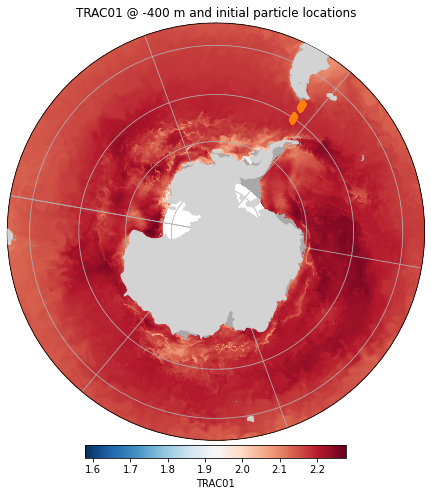

In [7]:
fig,ax = plt.subplots(figsize=(8,8),
                      subplot_kw={'projection':
                                      ccrs.SouthPolarStereo(
                                      central_longitude=-100)})
cmap = copy.copy(cm.RdBu_r)
cmap.set_bad('darkgray')
ax.set_extent([-180, 180, -90, -45], ccrs.PlateCarree())
# Compute a circle in axes coordinates, which we can use as a boundary
# for the map. We can pan/zoom as much as we like - the boundary will be
# permanently circular.
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
ax.set_boundary(circle, transform=ax.transAxes)

im=ax.pcolormesh(ds["XC"],ds["YC"],da_masked,cmap=cmap,
              transform=ccrs.PlateCarree())
plt.colorbar(im,ax=ax,
             orientation='horizontal',
            fraction=0.03,pad=0.01,
            label=varstr)

ax.plot(lons,
        lats,
        linestyle='None',
        marker='d',
        color='tab:orange',
        transform=ccrs.PlateCarree())

ax.add_feature(cfeature.LAND, zorder=10,facecolor='lightgray')
ax.gridlines()
ax.set_title(
    varstr+(' @ %s m'%depthV[1])+' and initial particle locations');

In [8]:
varstr = "THETA"
iselect = {"time":-1}
selectslice = {"YC":slice(-65,-50)}
lonV = 360-66
select = {"XC":lonV}
da = ds[varstr].isel(
    **iselect).sel(
    **select,method='nearest').sel(
    **selectslice)
da_masked = np.ma.masked_where(da==0,da)

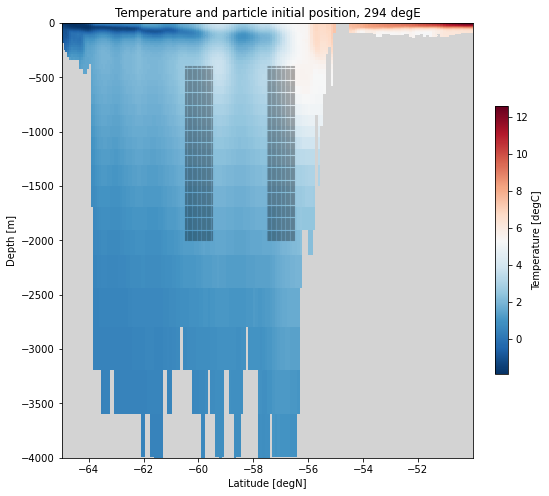

In [9]:
fig,ax = plt.subplots(figsize=(8,8))
cmap = copy.copy(cm.RdBu_r)
cmap.set_bad('lightgray')
im = ax.pcolormesh(da['YC'],da['Z'],da_masked,shading='auto',cmap=cmap)
ax.plot(lats,
        depths,
        linestyle='None',
        marker='.',
        color='k',
        markersize=0.1)
ax.set_ylabel('Depth [m]')
ax.set_xlabel('Latitude [degN]')
ax.set_title('Temperature and particle initial position, %s degE' %str(lonV))
ax.set_ylim([-4000,0])
plt.colorbar(im,ax=ax,
             fraction=0.03,pad=0.05,
             label='Temperature [degC]')

In [13]:
df

,Coral Sites,names,Latitude,Longitude,Depth,Unnamed: 5
0,Burdwood Bank (BB),BB,54.500000,62.166667,334.0,NaN
1,Burdwood Bank (BB),BB,54.500000,62.166667,727.0,NaN
2,Burdwood Bank (BB),BB,54.500000,62.166667,816.0,NaN
3,Burdwood Bank (BB),BB,54.500000,62.166667,1419.0,NaN
4,Burdwood Bank (BB),BB,54.500000,62.166667,1879.0,NaN
5,Cape Horn (CH),CH,57.166667,66.100000,450.0,NaN
6,Cape Horn (CH),CH,57.166667,66.100000,1012.0,NaN
7,Cape Horn (CH),CH,57.166667,66.100000,1214.0,NaN
8,Cape Horn (CH),CH,57.166667,66.100000,1441.0,NaN
9,Cape Horn (CH),CH,57.166667,66.100000,1877.0,NaN


In [ ]:
N = 50
lonV = 291-10
latV = [-75, -55]
depthV = [-3000,-200]

lats1D = np.linspace(latV[0],latV[1],N)
lons1D = np.arange(231,291,10)
depths1D = np.linspace(depthV[0],depthV[1],N)

[lons,lats,depths] = np.meshgrid(lons1D,lats1D,depths1D)